# Tutorial Fisher-Kolmogorov Equation

The goal is to fit a tumor model to existing tumor segmentation and PET data if existing. 


In [3]:
import numpy as np
import os
import nibabel as nib
import time
from scipy import ndimage
import nibabel as nib
import matplotlib.pyplot as plt
import cmaesFK
import tools


### Load white and grey matter mask of the brain

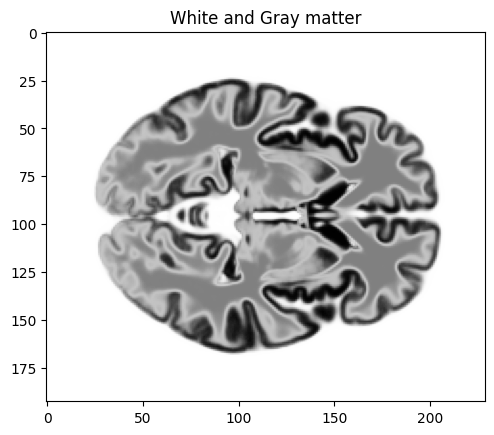

In [4]:
WM = nib.load("exampleData/wm_data.nii.gz").get_fdata()
GM = nib.load("exampleData/gm_data.nii.gz").get_fdata()

plt.title("White and Gray matter")
zSlice = 75
plt.imshow(GM[:, :, zSlice],  cmap="Grays", alpha=1 *GM[:, :, 75])
plt.imshow(WM[:, :, zSlice],  cmap="Grays", alpha=0.5*WM[:, :, 75])  
plt.show()

### Load the tumor segmentation that we want to fit a model to

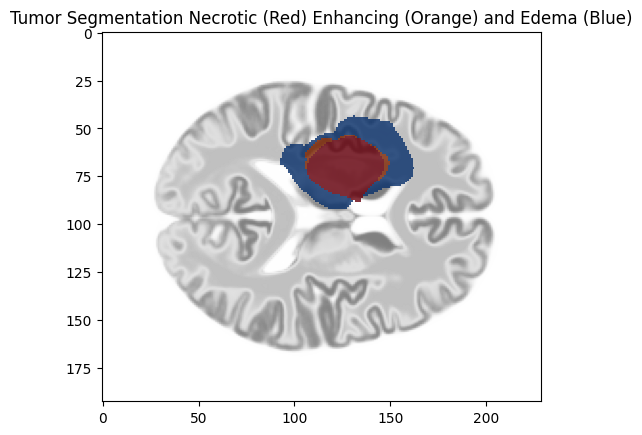

In [8]:

segmentation = nib.load("exampleData/tumor_seg.nii.gz").get_fdata()

edema = np.logical_or(segmentation == 3, segmentation == 2)
necrotic = segmentation == 1
enhancing = segmentation == 4

# plotting
zSlice = int(ndimage.center_of_mass(edema)[2])
plt.title("Tumor Segmentation Necrotic (Red) Enhancing (Orange) and Edema (Blue)")
plt.imshow(GM[:, :, zSlice],  cmap="Grays", alpha=0.5 *GM[:, :, zSlice])
plt.imshow(WM[:, :, zSlice],  cmap="Grays", alpha=0.25*WM[:, :, zSlice])  
plt.imshow(0.99 * enhancing[:, :, zSlice],  cmap="Oranges", alpha=0.8 * enhancing[:, :, zSlice], label = "enhancing", interpolation="none")
plt.imshow(0.99 * necrotic[:, :, zSlice],  cmap="Reds", alpha=0.8 * necrotic[:, :, zSlice], label = "necrotic", interpolation="none")
plt.imshow(0.99 * edema[:, :, zSlice],  cmap="Blues", alpha=0.8* edema[:, :, zSlice], label = "edema", interpolation="none")
plt.show()

### Load the PET data (positron emission tomography)
If you don't have PET data, you can set every value to 0

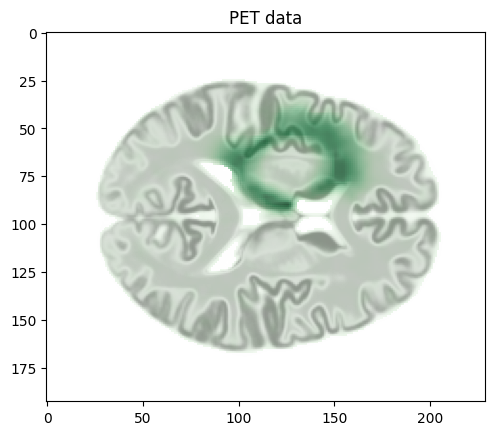

In [10]:
pet = nib.load("exampleData/FET.nii.gz").get_fdata()
pet = pet / np.max(pet)

plt.title("PET data")
plt.imshow(GM[:, :, zSlice],  cmap="Grays", alpha=0.5 *GM[:, :, zSlice])
plt.imshow(WM[:, :, zSlice],  cmap="Grays", alpha=0.25*WM[:, :, zSlice])
plt.imshow(pet[:, :, zSlice],  cmap="Greens", alpha=0.8* pet[:, :, zSlice], interpolation="none")
plt.show()

### Settings for Covariance Matrix Adaptation Evolution Strategy (CMA-ES)

In [13]:
settings = {}

# initial parameters for the total time is fix to T=100
settings["rho0"] = 0.06 # initial proliferation rate
settings["dw0"] = 0.001 # initial diffusion coefficient
settings["thresholdT1c"] = 0.675 # initial threshold for enhancing tumor
settings["thresholdFlair"] = 0.25 # initial threshold for edema

# center of mass
com = ndimage.center_of_mass(edema)

# set initial position of the tumor at the center of mass
settings["NxT1_pct0"] = float(com[0] / np.shape(edema)[0])
settings["NyT1_pct0"] = float(com[1] / np.shape(edema)[1])
settings["NzT1_pct0"] = float(com[2] / np.shape(edema)[2])

# possible ranges for the parameters from left to right
# NxT1_pct, NyT1_pct, NzT1_pct, , rho, dw, thresholdT1c, thresholdFlair
settings["parameterRanges"] = [[0, 1], [0, 1], [0, 1], [0.0001, 0.225], [0.001, 3], [0.5, 0.85], [0.001, 0.5]] 

# multiprocessing
settings["workers"] = 9

# initial sigma - hyper parameter for the solver
settings["sigma0"] = 0.02

# resolution factor for the forward model
# It can change with generations: key = from relative generations , value = resolution factor
# i.e. {0:0.6, 0.5:1.0} means that the first half of the run is with 60% resolution and the second with 100%  
settings["resolution_factor"] = { 0: 0.3, 0.7: 0.5} 

# number of generations for the algorithm
settings["generations"] = 12 # there are 9 samples in each step

## Now start the CMA-ES optimization
This might take a few minutes to hours depending on the resolution, generations and number of workers

In [14]:
solver = cmaesFK.CmaesSolver(settings, WM, GM, edema, enhancing, pet, necrotic)
resultTumor, resultDict = solver.run()

# save results
resultpath = "exampleResults/"
os.makedirs(resultpath, exist_ok=True)
np.save(resultpath + "gen_"+ str(settings["generations"]) + "_settings.npy", settings)
np.save(resultpath + "gen_"+ str(settings["generations"]) + "_results.npy", resultDict)
tools.writeNii(resultTumor, path = resultpath+"gen_"+ str(settings["generations"]) +"_result.nii.gz")

generations  1 / 13
run:  [3.51813392e-01 5.35518810e-01 4.69030352e-01 1.00000000e-04
 4.69128830e-02]
run:  [3.55678168e-01 5.54527984e-01 4.62566655e-01 1.00000000e-04
 3.68494759e-02]
run:  [3.50987292e-01 5.14148736e-01 5.04794244e-01 1.00000000e-04
 6.37955589e-02]
loss:  0.9992963101272034 lossDir:  {'lossFlair': 1.0, 'lossT1c': 1.0, 'lossPet': 1.0008898202018117, 'lossTotal': 0.9992963101272034, 'time': 1.066606044769287, 'allParams': array([3.51813392e-01, 5.35518810e-01, 4.69030352e-01, 1.00000000e-04,
       4.69128830e-02, 6.92583922e-01, 2.55108487e-01]), 'resolution_factor': 0.3} x:  [3.51813392e-01 5.35518810e-01 4.69030352e-01 1.00000000e-04
 4.69128830e-02 6.92583922e-01 2.55108487e-01]
run:  [0.34331823 0.54748227 0.46819603 0.00089475 0.07152733]
loss:  0.9994304349298455 lossDir:  {'lossFlair': 1.0, 'lossT1c': 1.0, 'lossPet': 1.0012925973869231, 'lossTotal': 0.9994304349298455, 'time': 1.0623512268066406, 'allParams': array([3.55678168e-01, 5.54527984e-01, 4.6256665

### Plot the final tumor
Have a look at "exampleResults/" for the nifti file.

Total runtime:  1.6 min


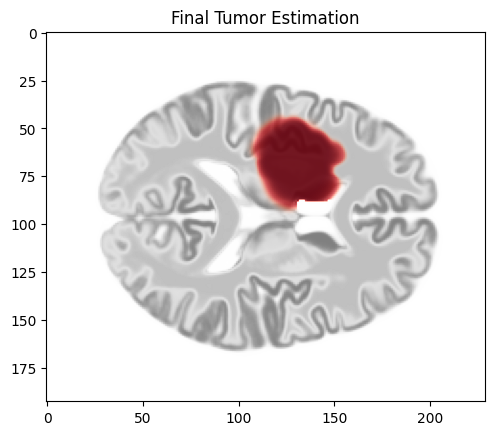

In [28]:
zSlice = int(ndimage.center_of_mass(edema)[2])

plt.title("Final Tumor Estimation")
plt.imshow(GM[:, :, zSlice],  cmap="Greys", alpha=0.5 *GM[:, :, zSlice])
plt.imshow(WM[:, :, zSlice],  cmap="Greys", alpha=0.25*WM[:, :, zSlice])
plt.imshow(resultTumor[:, :, zSlice],  cmap="Reds", alpha=0.9* resultTumor[:, :, zSlice])

print("Total runtime: ", round(resultDict["time_min"], 1), "min")

### A short analysis
For further analysis reffere to analysis.py and input the _results.npy file


minLoss 0.5939820067064342
opt [0.36971735 0.57157037 0.45910551 0.20700132 0.17989019 0.67777214
 0.13255606]
bestLossDir {'lossFlair': 0.8208470456647523, 'lossT1c': 0.3191328825560812, 'lossPet': 0.6437498216483382, 'lossTotal': 0.5939820067064342, 'time': 2.243447780609131, 'allParams': array([0.36971735, 0.57157037, 0.45910551, 0.20700132, 0.17989019,
       0.67777214, 0.13255606]), 'resolution_factor': 0.5}
----------------------------
best Total loss  0.5939820067064342
best Pet corr    0.35625017835166184
best T1c dice    0.6808671174439188
best Flair dice  0.1791529543352477


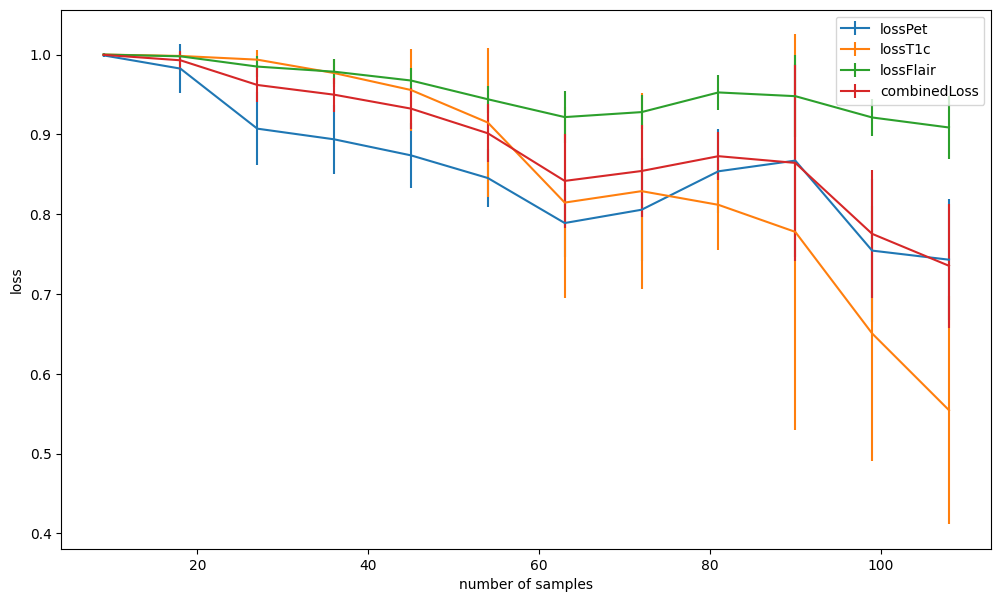

In [18]:

res = resultDict

lossDir = res["lossDir"]
minLoss = 1
for i in range(len(lossDir)):
    for j in range(len(lossDir[i])):
        if lossDir[i][j]["lossTotal"] < minLoss:
            minLoss = lossDir[i][j]["lossTotal"]
            opt = lossDir[i][j]["allParams"]
            bestLossDir = lossDir[i][j]

print("minLoss", minLoss)
print("opt", opt)
print("bestLossDir", bestLossDir)

print("----------------------------")

print("best Total loss ", bestLossDir["lossTotal"])
print("best Pet corr   ", 1-bestLossDir["lossPet"])
print("best T1c dice   ", 1-bestLossDir["lossT1c"])
print("best Flair dice ", 1-bestLossDir["lossFlair"])

#%%

lossPet, lossT1c, lossFlair, times, xs, resfactor = [], [], [], [], [], []
for i in range(len(res["lossDir"])):
    lossPet_, lossT1c_, lossFlair_, times_, xs_, resfactor_ = [], [], [], [], [], []
    for j in range(len(res["lossDir"][i])):
        if not res["lossDir"][i][j]["lossTotal"] <=1:
            print("error", i, j, res["lossDir"][i][j]["lossTotal"])
        if not res["lossDir"][i][j]["lossTotal"] >=0:
            print("error", i, j, res["lossDir"][i][j]["lossTotal"])
        if not res["lossDir"][i][j]["lossTotal"] == res["lossDir"][i][j]["lossTotal"]:
            print("error", i, j, res["lossDir"][i][j]["lossTotal"])
        lossPet_.append(res["lossDir"][i][j]["lossPet"])
        lossT1c_.append(res["lossDir"][i][j]["lossT1c"])
        lossFlair_.append(res["lossDir"][i][j]["lossFlair"])
        times_.append(res["lossDir"][i][j]["time"])
        xs_.append(res["lossDir"][i][j]["allParams"])
        try:
            resfactor_.append(res["lossDir"][i][j]["resolution_factor"])
        except:
            resfactor_.append(1)
    lossPet.append(lossPet_)
    lossT1c.append(lossT1c_)
    lossFlair.append(lossFlair_)
    times.append(times_)
    xs.append(xs_)
    resfactor.append(resfactor_)

times = np.array(times )/60
xs = np.array(xs)

#%%
plt.figure(figsize=(12, 7))	

combinedLoss = (np.array(lossPet) + np.array(lossT1c) + np.array(lossFlair) )/3
plt.errorbar(res["nsamples"], np.mean(lossPet, axis=1), yerr=np.std(lossPet, axis=1), label="lossPet")
plt.errorbar(res["nsamples"], np.mean(lossT1c, axis=1), yerr=np.std(lossT1c, axis=1),   label="lossT1c")
plt.errorbar(res["nsamples"], np.mean(lossFlair, axis=1), yerr=np.std(lossFlair, axis=1),   label="lossFlair")
plt.errorbar(res["nsamples"], np.mean(combinedLoss, axis=1), yerr=np.std(combinedLoss, axis=1),   label="combinedLoss")
plt.ylabel("loss")
plt.xlabel("number of samples")
plt.legend()


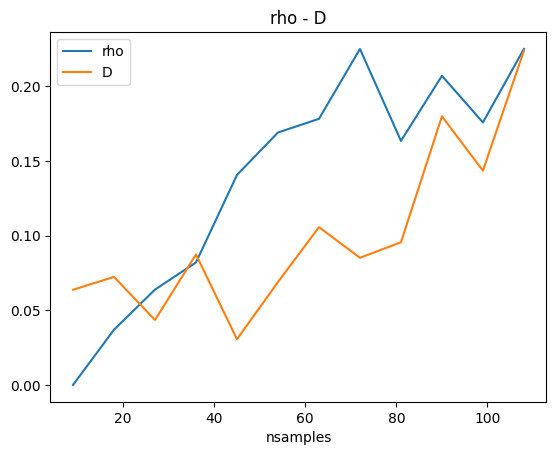

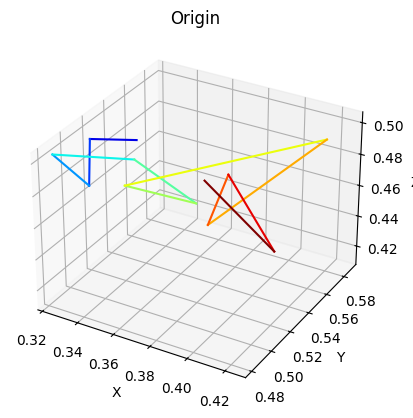

In [19]:

# %%
params = np.array(res["xs0s"])
plt.title("rho - D")
plt.plot(res["nsamples"], params.T[3], label="rho")
plt.plot(res["nsamples"],params.T[4], label="D")
plt.xlabel("nsamples")
plt.legend()

# %%
x = params.T[0]   
y = params.T[1]
z = params.T[2]

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assuming you have x, y, and z data
# Create a colormap based on the z values
colors = plt.cm.jet(np.linspace(0, 1, len(z)))

# Plot each segment with a different color
for i in range(1, len(x)):
    ax.plot(x[i-1:i+1], y[i-1:i+1], z[i-1:i+1], color=colors[i])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Origin")
plt.show()

